<a href="https://colab.research.google.com/github/ucaokylong/LLM_learning/blob/main/Multimodal_Visual_question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

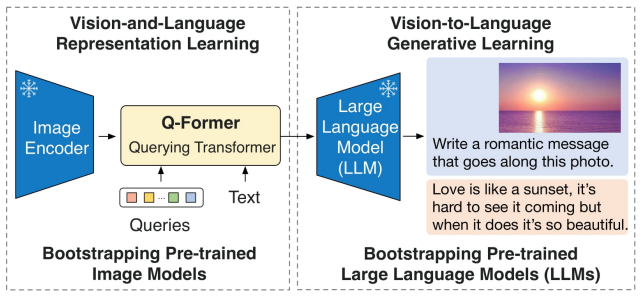

In [8]:
!unzip /content/IconDomainVQAData.zip

Streaming output truncated to the last 5000 lines.
  inflating: IconDomainVQAData/test_data/test_data/92789/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/92789/._data.json  
  inflating: IconDomainVQAData/test_data/test_data/92789/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/92789/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/49128/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/49128/._data.json  
  inflating: IconDomainVQAData/test_data/test_data/49128/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/49128/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/55745/data.json  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/55745/._data.json  
  inflating: IconDomainVQAData/test_data/test_data/55745/image.png  
  inflating: __MACOSX/IconDomainVQAData/test_data/test_data/55745/._image.png  
  inflating: IconDomainVQAData/test_data/test_data/2418

In [2]:
# Visual Question Answering using BLIP-2
!pip install -q peft transformers bitsandbytes datasets

import os
import torch
from PIL import Image










In [3]:
class VQADataset(torch.utils.data.Dataset):

  def __init__(self, dataset, processor, data_path):
    self.dataset = dataset
    self.processor = processor
    self.data_path = data_path

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    #get image + text
    question = self.dataset[idx]['question']
    answer = self.dataset[idx]['answer']
    image_id = self.dataset[idx]['pid']
    image_path = os.path.join(self.data_path ,f"train_fill_in_blank/train_fill_in_blank/{image_id}/image.png")
    image = Image.open(image_path).convert("RGB")
    text = question
    encoding = self.processor( image , text , padding ="max_length", truncation = True ,
                                 return_tensors ="pt")
    labels = self.processor.tokenizer.encode(answer , max_length = 8 , pad_to_max_length = True , return_tensors ='pt')
    encoding["labels"] = labels
    for k , v in encoding.items(): encoding[k] = v.squeeze()
    return encoding


In [4]:
import torch
from peft import LoraConfig , get_peft_model
from transformers import BlipProcessor , BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

config = LoraConfig(r =16 , lora_alpha =32 ,
                    lora_dropout =0.05 , bias ="none",
                    target_modules =["query", "key"])

model = get_peft_model( model , config)
device = torch.device("cuda" if torch.cuda.is_available () else "cpu")
model.to( device )
model.print_trainable_parameters()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6095870120958619


In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


data_path = './IconDomainVQAData'
split_ratio = 0.8
ds = load_dataset("json", data_files = f"{data_path}/train.jsonl")
split_ds = ds['train'].train_test_split(test_size = 1 - split_ratio)

train_dataset = split_ds['train']
val_dataset = split_ds['test']


train_dataset = VQADataset(
    dataset = train_dataset ,
    processor = processor ,
    data_path = data_path)

valid_dataset = VQADataset(
    dataset = val_dataset ,
    processor = processor ,
    data_path = data_path)

batch_size = 8

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True , pin_memory = True )
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size , shuffle = False ,pin_memory = True )



























NameError: name 'VQADataset' is not defined

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.AdamW( model.parameters() , lr =4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer , gamma =0.9 , last_epoch= -1 , verbose = False)

num_epochs = 1
min_eval_loss = float("inf")
scaler = torch.cuda.amp.GradScaler()

for epoch in range( num_epochs ):
  epoch_loss = []
  model.train()
  for idx , batch in zip(tqdm( range(len(train_dataloader)), desc = f'Training batch : {epoch +1}') , train_dataloader):
    input_ids = batch.pop('input_ids').to( device )
    pixel_values = batch.pop('pixel_values').to( device )
    attention_masked = batch.pop('attention_mask').to(device)
    labels = batch.pop('labels').to( device )

    with torch.amp.autocast( device_type ='cuda', dtype = torch.float16 ):
      outputs = model(input_ids = input_ids ,pixel_values = pixel_values ,labels = labels)

    loss = outputs.loss
    epoch_loss.append(loss.item())

    optimizer.zero_grad()
    scaler.scale( loss ).backward()
    scaler.step( optimizer )
    scaler.update()

  model.eval()
  valid_loss = []

  for idx, batch in zip(tqdm(range(len(valid_dataloader)) , desc = f'Validating batch: {epoch +1}') , valid_dataloader):
    input_ids = batch.pop('input_ids').to(device)
    pixel_values = batch.pop('pixel_values').to( device )
    attention_masked = batch.pop('attention_mask').to( device )
    labels = batch.pop('labels').to( device )

    with torch.amp.autocast( device_type ='cuda', dtype = torch.float16 ):
      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      attention_mask = attention_masked,
                      labels=labels)

    loss = outputs.loss
    valid_loss.append(loss.item())

  print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, sum(epoch_loss)/len(epoch_loss), sum(valid_loss)/len(valid_loss),
                                                                        optimizer.param_groups[0]["lr"]))
  scheduler.step()
  avg_loss = sum(valid_loss)/len(valid_loss)
  if avg_loss < min_eval_loss:
    model.save_pretrained("./save_model", from_pt=True)
    print("Saved model to ./save_model")
    min_eval_loss = valid_loss

processor.save_pretrained("./save_model", from_pt=True)









/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training batch : 1:   0%|          | 0/1819 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_

In [ ]:
import json
processor = BlipProcessor.from_pretrained("./save_model")
model = BlipForQuestionAnswering.from_pretrained("./save_model").to( device )
test_data_dir = f"{data_path}/test_data/test_data"
samples = os.listdir( test_data_dir )
sample_path = f"{data_path}/test_data/test_data/{samples[0]}"


# read question , image id
json_path = os.path.join( sample_path , " data.json")
with open( json_path , "r") as json_file:
  data = json.load( json_file )
  question = data["question"] # How many diamonds are there ?
  image_id = data["id"]


# load image
image_path = os.path.join( test_data_dir , f"{image_id}", "image.png")
image = Image.open( image_path ).convert ("RGB")

encoding = processor( image , question , return_tensors ="pt").to( device , torch.float16 )

out = model.generate(**encoding)
generated_text = processor.decode( out[0] , skip_special_tokens = True )

generated_text
